# Guillermo Gallego Reina - Real estate price prediction

Se busca analizar el mercado de la vivienda en Madrid para comprender los factores que afectan al precio del alquiler. El conjunto de datos utilizado tiene como variable target("Rent") y adicionalmente se cuenta con datos de las zonas.

El objetivo es definir un problema de machine learning llevando a cabo el proceso de limpieza de datos, ingeniería de variables, análisis exploratorio proporcionando algunas ideas, preparar los datos y entrenar un modelo de aprendizaje automático.

En este caso se realizará usando pyspark para todo el proceso.

In [0]:
import pandas as pd
import numpy as np
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window
import unicodedata
import seaborn as sns

# LECTURA DATOS

In [0]:
df1 = spark.sql("SELECT * FROM default.mercado_inmobiliario_csv")
df2 = spark.sql("SELECT * FROM default.informacion_adicional_zonas_csv")

#Se eliminara Id dado que no hace referencia a nada de las viviendas.
df1 = df1.drop('Id')
df1 = df1.withColumnRenamed('Sq._Mt.','SqMt')

# Analisis Descriptivo

##Dataframe mercado_inmobiliario_csv

In [0]:
df1.printSchema()

root
-- Area: string (nullable = true)
-- Address: string (nullable = true)
-- Number: string (nullable = true)
-- Zone: string (nullable = true)
-- Bedrooms: integer (nullable = true)
-- SqMt: string (nullable = true)
-- Floor: integer (nullable = true)
-- Outer: integer (nullable = true)
-- Elevator: string (nullable = true)
-- Penthouse: integer (nullable = true)
-- Cottage: integer (nullable = true)
-- Duplex: integer (nullable = true)
-- Semi-detached: integer (nullable = true)
-- Rent: string (nullable = true)

In [0]:
#Descripcion de las variables estadisticas
df1.describe().show()

+-------+----------+--------------------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
summary| Area| Address| Number| Zone| Bedrooms| SqMt| Floor| Outer| Elevator| Penthouse| Cottage| Duplex| Semi-detached| Rent|
+-------+----------+--------------------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
 count| 2188| 2183| 771| 2184| 2090| 2188| 2031| 2006| 2042| 2188| 2188| 2188| 2188| 2177|
 mean| null| null|36.50938337801609| null| 2.496172248803828| 128.0989010989011|24.753323485967503|0.8678963110667997|0.8803921568627451|0.07769652650822668|0.04524680073126142|0.029707495429616086|0.015082266910420476| 795.418060200669|
 stddev| null| null|47.43685926083239| null|1.3091842197344647|109.14625723463534| 954.9340279524083|0.3386878909816633|0.3245819632169392|0.26775463118512044| 0.2078924737101702| 0.16981796218938638| 0.12190809837706174|121.67851403929313|
 min|Arganzuela|Casa o chalet ind...| Trafalgar|12 de Octubre-Orc...| 0| 1,160| -1| 0| 0| 0| 0| 0| 0| 1,000|
 max| moncloa|Ático en san agu...| 99| Águilas| 8| 99| 43039| 1| interior| 1| 1| 1| 1| 999|
+-------+----------+--------------------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+

In [0]:
#Valores Missing
df1.select([count(when((col(c)=='') | col(c).isNull() |isnan(c), c)).
alias(c) for c in df1.columns]).show()

+----+-------+------+----+--------+----+-----+-----+--------+---------+-------+------+-------------+----+
Area|Address|Number|Zone|Bedrooms|SqMt|Floor|Outer|Elevator|Penthouse|Cottage|Duplex|Semi-detached|Rent|
+----+-------+------+----+--------+----+-----+-----+--------+---------+-------+------+-------------+----+
 0| 5| 1417| 4| 98| 0| 157| 182| 146| 0| 0| 0| 0| 11|
+----+-------+------+----+--------+----+-----+-----+--------+---------+-------+------+-------------+----+

In [0]:
df1.groupby(df1['Zone']).count().sort(desc("count")).show(10, False)

+-----------------------+-----+
Zone |count|
+-----------------------+-----+
Recoletos |98 |
Chueca-Justicia |87 |
Castellana |77 |
Goya |75 |
Argüelles |63 |
Almagro |56 |
Cuatro Caminos |53 |
Bernabéu-Hispanoamérica|49 |
Nueva España |48 |
Malasaña-Universidad |48 |
+-----------------------+-----+
only showing top 10 rows

##Dataframe informacion_adicional_zonas_csv

In [0]:
df2.printSchema()

root
-- Zone: string (nullable = true)
-- Rent_mean: integer (nullable = true)
-- Zip_Code: double (nullable = true)
-- Num_schools: integer (nullable = true)
-- Num_parks: integer (nullable = true)
-- Num_banks: integer (nullable = true)

In [0]:
#Descripcion de las variables estadisticas
df2.describe().show()

+-------+-------+------------------+------------------+------------------+------------------+-----------------+
summary| Zone| Rent_mean| Zip_Code| Num_schools| Num_parks| Num_banks|
+-------+-------+------------------+------------------+------------------+------------------+-----------------+
 count| 34| 34| 34| 34| 34| 34|
 mean| null|2255.8529411764707| 28044.0|15.911764705882353|7.4411764705882355|21.91176470588235|
 stddev| null| 762.8858341194822|136.28201597711958| 5.218659104794057|2.7324223515606767|7.921461630734661|
 min|Almagro| 1118| 28001.0| 7| 3| 7|
 max| Sol| 3918| 28810.0| 24| 11| 34|
+-------+-------+------------------+------------------+------------------+------------------+-----------------+

In [0]:
#Valores Missing
df2.select([count(when((col(c)=='') | col(c).isNull() |isnan(c), c)).
alias(c) for c in df2.columns]).show()

+----+---------+--------+-----------+---------+---------+
Zone|Rent_mean|Zip_Code|Num_schools|Num_parks|Num_banks|
+----+---------+--------+-----------+---------+---------+
 0| 0| 0| 0| 0| 0|
+----+---------+--------+-----------+---------+---------+

###Conclusiones Analisis Descriptivo

**mercado_inmobiliario_csv**
* **id:** Se elimara el id dado que indica el valor del indice.
* **Area:** Area donde se ubica la vivienda.
* **Addres:** Indica la direccion de la vivienda, en este caso se realizara un limpieza para obtener unicamente la calle donde se ubica.
* **Number:** Numero de la calle de donde se encuentra la vivienda, dado el gran numero de missing se rellenaran con lo ultimos valores recogidos en funcion del Area y la Zone.
* **Zone:** Zona de madrid donde se encuentra la vivienda.
* **Bedrooms:** Numero de habitaciones que tenemos en la vivienda, en este caso para los missing se rellenaran en funcion del criterio de los metros cuadrados que tiene la vivienda.
* **SqMt:** Numero de metros cuadrados de la vivienda.
* **Floor:** Numero de donde esta ubicada la vivienda, en este caso para los missing se considera como que la vivienda esta sobre el nivel del suelo y se rellenara con 0. Esto se ha comprobado con la variable elevator dando la mayoria que no tiene ascensor.
* **Outer:** Indica si la vivienda cuenta con ventanas orientadas hacia una vía pública en todas las habitaciones principales. En el caso de los missing values tomaremos que la vivienda que no esta orienda hacia ningun via publica y lo rellenaremos con 0.
* **Elevator:** Indica si la vivienda tiene ascensor.
* **Penthouse:** Indica si es un atico.
* **Cottage:** Indica si es un chalet.
* **Dupplex:** Indica si es un duplex.
* **Semi-detached:** Indica si es un adosado.
* **Rent:** Indica el valor del alquiler, en nuestro caso este sera el Target a predecir.

**informacion_adicional_zonas_csv**

* **Zone:** Zona de madrid donde se encuentra la vivienda.
* **Rent_mean:** Hace referencia a la renta media en esa zona, esta es un falso predictor porque se crea a partir de los valores de la rent por lo que la eliminaremos.
* **ZipCode:** Hace referencia al codigo postal de la zona. 
* **Num_chools:** Hace referencia al numero de colegios ubicados en la zona.
* **Num_arks:** Hace referencia al numero de aparacamientos que hay en la zona.
* **Num_anks:** Hace referencia la numero de bancos que hay en la zona

Ambas tablas se uniran por la variable Zone, como hemos podido ver despues de eliminar los duplicados en la variable zone de **formacion_adicional_zonas_csv**os queda un total de **25 zones**, este valor es mas pequeno de las zonas que vienen en la variable zone de mercado_inmobiliario_csv. Con lo anterior concluimos que se reduccira mucho las muestras al hacer el join, por lo que para futuros analisis habria que obtener mas zones con los datos de num_banks, etc...

# Limpieza

In [0]:
#Se creara un nueva columna house_cat para categorizar las casas en funcion de los metros cuadrados
df1 = df1.withColumn('house_cat',lit(0))
#Se realiza la limpieza de las direcciones
df1 = df1.withColumn('Address',regexp_replace('Address', 'Piso en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Ático en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Estudio en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Chalet adosado en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Chalet pareado en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Casa o chalet independiente en', ''))\
        .withColumn('Address',regexp_replace('Address', 'Dúplex en', ''))\
        .withColumn('Address',lower(ltrim(col('Address'))))
#Le asignaremos un 0 a los valores con Address None ya que posteriomente se relaizra una categorizacion de las direcciones
df1 = df1.na.fill('0', subset=['Address'])

#Dado la importancia que tiene Number para las muestras se rellenara los missing con el ultimo valor no null encontrado en funcion del Area y la Zone.
window = Window.partitionBy('Area')\
               .orderBy('Zone')\
               .rowsBetween(-sys.maxsize, 0)

filled_column = last(df1['Number'], ignorenulls=True).over(window)
df1 = df1.withColumn('Number', filled_column)
#Dado que tenemos la arquitectura de spark los que haya encontrado null como ultimo valor se le indicara el valor de 1
df1 = df1.na.fill('1', subset=['Number'])
#Eliminamos los espacios por delante
df1 = df1.withColumn("Number", trim(col('Number')))
#En el caso de tener s/n vamos ha remplanzar por 0 para reforzar que es un vivienda sin numero.
df1 = df1.withColumn('Number',regexp_replace('Number', 's/n', '0'))
#Se ha comprobado que existen dos registros donde le numero viene como Trafalgar por lo que se eliminaran
df1 = df1.filter(col('Number') != 'Trafalgar')
df1 = df1.withColumn("Number",col('Number').cast('int'))

#Se eliminan aquellos registros que estan duplicados
df1 = df1.drop_duplicates()

#En el caso de la zone dado que solo tiene 4 missing values los eliminaremos.
df1 = df1.dropna(subset=['Zone'])
#Eliminamos los espacios por delante
df1 = df1.withColumn("Elevator", trim(col('Elevator')))
# Se ha encontrado string en la variable, por lo que se rellenara con 0 asumiendo que no tiene ascensor.
df1 = df1.withColumn("Elevator", regexp_replace('Elevator', 'interior', '0'))\
         .withColumn("Elevator", regexp_replace('Elevator', 'Bajo', '0'))
df1 = df1.na.fill('0', subset=['Elevator'])
df1 = df1.withColumn("Elevator",col('Elevator').cast('int'))

# Se elimira la coman y se dejara como un valor entero.
df1 = df1.withColumn("Rent", regexp_replace('Rent', ',', ''))\
         .withColumn("Rent",col('Rent').cast('int'))

# Se elimira la coman y se dejara como un valor entero.
df1 = df1.withColumn("SqMt", regexp_replace('SqMt', ',', ''))\
         .withColumn("SqMt",col('SqMt').cast('int'))

#Rellenamos los missing values  segun la  regla estimada en funcion de los metros cuadrados
df1 = df1.withColumn(
    'Bedrooms', 
    coalesce(
        col('Bedrooms'),
        when(col('SqMt') <=50, 1)
        .when((col('SqMt') >50) & (col('SqMt') <= 75), 2)
        .when(col('SqMt') >75, 3)))

# Para el floor vamos a considerar que los valores missing no tiene plantas, esto se ha comprobado con la variable elevator y en 
#ellas se marca como que no tiene ascensor. No es algo mandotorio pero correla con las plantas y consideramos que esta
#en el piso sobre la planta del suelo.
df1 = df1.withColumn("Floor", regexp_replace('Floor', 'NaN', 'null'))
df1 = df1.na.fill('0', subset=['Floor'])
df1 = df1.withColumn("Floor",col('Floor').cast('int'))

#Para ver si tiene exterior(Outer) tenemos que buscar la definicion de Outer: 
#Son aquellas viviendas situadas dentro de un edificio que cuentan con ventanas orientadas
#hacia una vía pública en todas las habitaciones principales.
#En nuestro caso se han analizado los diferentes casao y los valore null se consideraran como casa que no dan al exterior
#y por tanto le asginaremos un valor de 0

df1 = df1.withColumn("Outer", regexp_replace('Outer', 'NaN', 'null'))
df1 = df1.na.fill('0', subset=['Outer'])
df1 = df1.withColumn("Outer",col('Outer').cast('int'))

#Categorizamos la variable house_cat, relizaremos una agrupacion de la casa en funcion de los metros cuadrados
#https://elpais.com/economia/2016/03/24/actualidad/1458814797_669980.html

df1 = df1.withColumn('house_cat', when(col('SqMt') <= 103, '0')\
                     .when((col('SqMt') > 103) & (col('SqMt') <= 147), '1')\
                     .when((col('SqMt') > 147) & (col('SqMt') <= 191), '2')\
                     .when((col('SqMt') > 191) & (col('SqMt') <= 234), '3')\
                     .when((col('SqMt') > 234) & (col('SqMt') <= 278), '4')\
                     .when((col('SqMt') > 278) & (col('SqMt') <= 328), '5')\
                     .when((col('SqMt') > 328) & (col('SqMt') <= 638), '6')\
                     .when(col('SqMt') > 638, '7'))
df1 = df1.withColumn("house_cat",col('house_cat').cast('int'))

In [0]:
# Dataframe2
df2 = df2.drop_duplicates()


In [0]:
#Realizamos el Join entre las dos tablas, sera por la variable Zone.
ds2 = df1.join(df2,how='inner',on='Zone')

# Outliers

Para la deteccion de Outliers nos basaremos en la tecnica del rango intercuartilico, solo se realizara sobre la variable Rent dado que no queremos alquileres fuera de los normal.

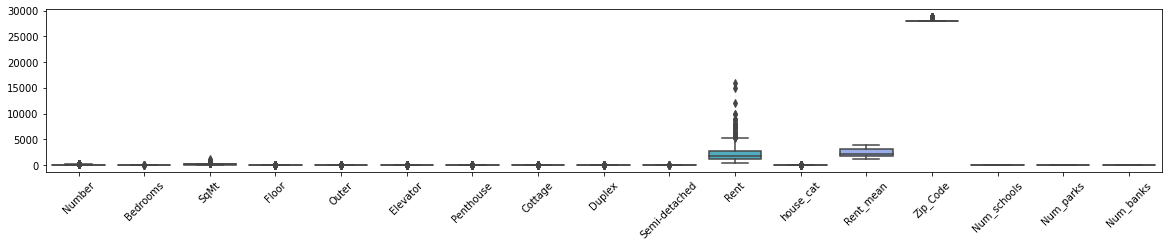

In [0]:
ds2pandas = ds2.toPandas()
_=plt.figure(figsize = [20,3])
sns.boxplot(data = ds2pandas)
_=plt.xticks(rotation = 45)

In [0]:
#Calculamos el Q1 y Q3.
bounds = {
    'Rent': dict(
        zip(["q1", "q3"], ds2.approxQuantile('Rent', [0.25, 0.75], 0))
    )
}

iqr = bounds['Rent']['q3'] - bounds['Rent']['q1']
#Calculamos los extremos para los outliers.
bounds['Rent']['lower'] = bounds['Rent']['q1'] - (iqr * 1.5)
bounds['Rent']['upper'] = bounds['Rent']['q3'] + (iqr * 1.5)

# Se creara un columna llamada Rent_out donde indica con 0 los valores que estan dentro de los limites y 1 los que estan fuera ( ) y por
#tanto un outlier
ds2 = ds2.withColumn('Rent_out',when(col("Rent").between(bounds['Rent']['lower'], bounds['Rent']['upper']),0).otherwise(1) )
#Seleccionamos los que nos son outliers
ds2 = ds2.filter(col("Rent_out") == 0)
#Eliminamos Rent_out
ds2 = ds2.drop('Rent_out')


# Feature Engineering

Se crea una nueva variable (**Feature1**) que esta comuesta de 'Bedrooms', 'SqMt', 'Floor', 'Elevator', posteriormente se eliminara estas.Esta variable ha sido calculada para obtener un valor mayor de correlacion con respecto a Rent.Desde el punto de vista de negocio esta variable es razonable ya que estas variables que lo componen son muy relevantes para el precio del alquiler.

Ademas dada la alta correlaccion dec Feature1 con Cottage  se eliminara esta para eliminar la colinialidad.

Out[39]:

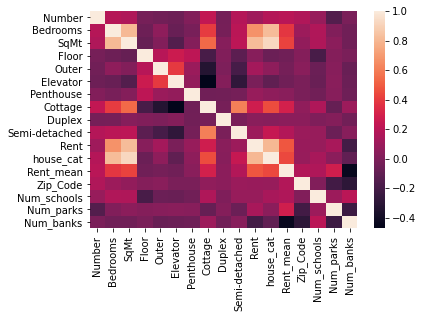

<AxesSubplot:>

In [0]:
sns.heatmap(ds2pandas.corr())

In [0]:
ds2pandas.corr()

Out[40]:

,Number,Bedrooms,SqMt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semi-detached,Rent,house_cat,Rent_mean,Zip_Code,Num_schools,Num_parks,Num_banks
Number,1.000000,0.185328,0.162966,-0.029594,-0.046661,-0.062566,0.013349,0.231751,-0.032596,0.179716,0.109636,0.182380,0.197725,0.165749,0.080184,-0.154074,-0.017789
Bedrooms,0.185328,1.000000,0.807593,-0.062894,0.051626,-0.080459,-0.019908,0.398503,-0.025094,0.200737,0.670801,0.819297,0.380947,0.097144,0.170059,0.009448,-0.051110
SqMt,0.162966,0.807593,1.000000,-0.083980,0.015175,-0.152646,0.017716,0.536416,0.025603,0.207313,0.818318,0.924820,0.421509,0.065178,0.160720,0.041710,-0.047383
Floor,-0.029594,-0.062894,-0.083980,1.000000,0.189594,0.266426,0.211822,-0.194435,0.009121,-0.117392,0.029528,-0.066727,-0.048532,0.016329,-0.191602,0.020323,-0.014311
Outer,-0.046661,0.051626,0.015175,0.189594,1.000000,0.394636,0.091208,-0.332741,-0.006142,-0.200896,0.127911,0.055797,-0.031417,0.037185,-0.065304,0.028138,-0.076534
Elevator,-0.062566,-0.080459,-0.152646,0.266426,0.394636,1.000000,0.073419,-0.473057,0.019219,-0.285613,-0.015984,-0.108331,-0.051020,-0.016213,-0.075297,0.034622,-0.067664
Penthouse,0.013349,-0.019908,0.017716,0.211822,0.091208,0.073419,1.000000,-0.052400,-0.044989,-0.031637,0.082348,0.052224,0.037909,-0.014797,-0.045399,0.029109,-0.053810
Cottage,0.231751,0.398503,0.536416,-0.194435,-0.332741,-0.473057,-0.052400,1.000000,-0.025861,0.603761,0.280056,0.448246,0.292325,0.056575,0.165220,-0.081913,0.101382
Duplex,-0.032596,-0.025094,0.025603,0.009121,-0.006142,0.019219,-0.044989,-0.025861,1.000000,-0.015614,0.038203,0.032003,0.040891,0.039660,0.003885,0.018356,-0.045306
Semi-detached,0.179716,0.200737,0.207313,-0.117392,-0.200896,-0.285613,-0.031637,0.603761,-0.015614,1.000000,0.096622,0.245987,0.175100,0.092316,0.081388,-0.067040,0.030754


In [0]:
# Se crea una nueva variable que esta comuesta de 'Bedrooms', 'SqMt', 'Floor', 'Elevator' y se eliminara estas.Esta variable ha sido calculada para obtener un valor mayor de correlacion con respecto a Rent. Desde el punto de vista de negocio esta variable es razonable que este ya las variables que lo componen son muy relevantes para el precio del alquiler.

# Ademas dada la alta correlaccion con Feature1 se eliminara Cottage para eliminar la colinialidad.
#Rent_mean: Hace referencia a la renta media en esa zona, esta es un falso predictor porque se crea a partir de los valores
# de la rent por lo que lo eliminaremos.
# 
coldrop = ['Bedrooms','Sq. Mt.','Floor','Elevator','Rent_mean','Cottage']
ds2 = ds2.withColumn('Feature1', col('Bedrooms')+col('SqMt')+col('Floor')+col('Elevator'))
ds2 = ds2.drop(*coldrop)

# MODELO MLIB

Una vez que tenemos realizada la limpieza vamos a construir el modelo, en nuestro caso dado la tipologia de los datos y los analisis descriptivos se va a seleccionar un Gradient-Boosted Trees (GBTs).

Para realizar esto se diseñara un pipeline que estara compuesto:

* **Primero se realizara un StringIndexer para transformar las variables categoricas en numericas para posteriomente aplicar un VectorAssembler particionando el dataset en 70 train y 30 test.**

* **Segundo se aplicara otro pipeline donde ya si indicaramos primeramente un Standarizacion y posteriormente aplicaremos el modelo.**


Finalmente para evaluar el modelo se mostraran las variables de coeficiente de determinacion y el MAE. Como se vera en los resultados hay mucho margen de mejora si se aumentara el numero de muestras.

In [0]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import StandardScaler, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

In [0]:
Address_indexer = StringIndexer(inputCol="Address", outputCol="Address_Cat")
Zone_indexer = StringIndexer(inputCol="Zone", outputCol="Zone_Cat")
Area_indexer = StringIndexer(inputCol="Area", outputCol="Area_Cat")


assembler_tr = VectorAssembler(inputCols=['Number', 'Outer', 'Penthouse', 'Duplex', 'Semi-detached',
       'house_cat', 'Zip_Code', 'Num_schools', 'Num_parks', 'Num_banks',
       'Area_Cat', 'Zone_Cat', 'Address_Cat', 'Feature1'], outputCol="features_all")

pipelinefeature = Pipeline(stages=[Address_indexer, Zone_indexer, Area_indexer,assembler_tr])

vector = pipelinefeature.fit(ds2).transform(ds2)
# Se deja el parametro seed para que no cambie en cada ejecución
vector_tr, vector_te = vector.randomSplit([0.7, 0.3], seed=1234)


scaler_es = StandardScaler(withMean=True, withStd=True, inputCol="features_all", outputCol="features")
gbt_es = GBTRegressor(labelCol='Rent')

# Estimator.
pipeline_es = Pipeline(stages=[scaler_es, gbt_es])

# Transformer.
pipeline_tr = pipeline_es.fit(vector_tr)

#Predecimos
pred_pipeline = pipeline_tr.transform(vector_te)

# Sacamos las metricas
evaluator = RegressionEvaluator(labelCol='Rent')

print("R2:   %5.2f" % evaluator.evaluate(pred_pipeline, {evaluator.metricName: "r2"}))
print("MAE:  %5.2f" % evaluator.evaluate(pred_pipeline, {evaluator.metricName: "mae"}))


R2: 0.76
MAE: 390.24

###Feature Importance

Como podemos ver las variables que mas influencia tiene el modelo son:
* **house_cat**: Es logico de cara a negocio dado la categorizacion esta en funcion de los metros cuadrados y este es un fator relevante.
* **Address_cat**: Categoriza la direccion y tambien es logico ya que en funcion de la direccion es mas barato o mas costoso el alquiler.
* **Feature1:** Como era de esperar ya que dicha variable ha sido preparada para mejorar el modelo.

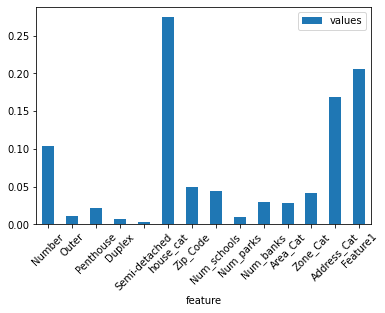

In [0]:
tr_x = np.array(['Number', 'Outer', 'Penthouse', 'Duplex', 'Semi-detached',
       'house_cat', 'Zip_Code', 'Num_schools', 'Num_parks', 'Num_banks',
       'Area_Cat', 'Zone_Cat', 'Address_Cat', 'Feature1'])

featureimp = pd.DataFrame([],columns=['feature','values'])
featureimp['feature'] = tr_x
featureimp['values'] = np.array(pipeline_tr.stages[1].featureImportances)
_=plt.figure(figsize=(5,4))
_=featureimp.plot.bar(x='feature', y='values', rot=45)

## Mejora de Hiperparametros

In [0]:
# Mejoramos los parametros por Default, para ello se realizara un Busqueda por Rejilla por medio de la Validacion Cruzada.
# Dado el pequeño computo del cluster que tengo en Databricks gasta mucho tiempo en buscar todo por lo que unicamente se ha planteado de lo que se haria, en este caso se buscaria maxDepth.

In [0]:
paramGrid = ParamGridBuilder()\
            .addGrid(gbt_es.maxDepth,[3,5,8]).build()

gbt_cv_es = CrossValidator(estimator=pipeline_es,
                      estimatorParamMaps=paramGrid,
                      evaluator=RegressionEvaluator(labelCol='Rent'),
                      numFolds=2,
                      seed=1234)

gbt_tr = gbt_cv_es.fit(vector_tr)
pred_cv = gbt_tr.transform(vector_te)


#Predecimos
pred_pipeline = pred_cv.transform(vector_te)

# Sacamos las metricas

print("R2:   %5.2f" % evaluator.evaluate(pred_pipeline, {evaluator.metricName: "r2"}))
print("MAE:  %5.2f" % evaluator.evaluate(pred_pipeline, {evaluator.metricName: "mae"}))
